In [ ]:
# Import libraries
## Basic libs
import pandas as pd
import numpy as np
import warnings
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Configure libraries
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')

In [ ]:
# Load dataset
df_bank = pd.read_csv('https://raw.githubusercontent.com/rafiag/DTI2020/main/data/bank.csv')

# Drop 'duration' column
df_bank = df_bank.drop('duration', axis=1)

# print(df_bank.info())
print('Shape of dataframe:', df_bank.shape)
df_bank.head()

Shape of dataframe: (11162, 16)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,-1,0,unknown,yes


In [ ]:
df_bank['deposit'].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

In [ ]:
df_bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [ ]:
#Scale Numeric Data
#Next up, we will scale our numerical data to avoid outlier presence that can significantly affect our model. 
#Using StandardScaler() function from sklearn we can scale each our columns that contains numerical data. The scaling will be done using the formula below:

#Z=X−U / S 

#Z:  scaled value

#X: original value

#U: mean of the data

#S: standard deviation of the data



from sklearn.preprocessing import StandardScaler

# Copying original dataframe
df_bank_ready = df_bank.copy()

scaler = StandardScaler()
num_cols = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
df_bank_ready[num_cols] = scaler.fit_transform(df_bank_ready[num_cols])

df_bank_ready.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,1.491505,admin.,married,secondary,no,0.252525,yes,no,unknown,-1.265746,may,-0.554168,-0.481184,-0.36326,unknown,yes
1,1.239676,admin.,married,secondary,no,-0.459974,no,no,unknown,-1.265746,may,-0.554168,-0.481184,-0.36326,unknown,yes
2,-0.019470,technician,married,secondary,no,-0.080160,yes,no,unknown,-1.265746,may,-0.554168,-0.481184,-0.36326,unknown,yes
3,1.155733,services,married,secondary,no,0.293762,yes,no,unknown,-1.265746,may,-0.554168,-0.481184,-0.36326,unknown,yes
4,1.071790,admin.,married,tertiary,no,-0.416876,no,no,unknown,-1.265746,may,-0.186785,-0.481184,-0.36326,unknown,yes


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Encode Categorical Data
df_encoded = pd.DataFrame(encoder.fit_transform(df_bank_ready[cat_cols]))
df_encoded.columns = encoder.get_feature_names(cat_cols)

# Replace Categotical Data with Encoded Data
df_bank_ready = df_bank_ready.drop(cat_cols ,axis=1)
df_bank_ready = pd.concat([df_encoded, df_bank_ready], axis=1)

# Encode target value
df_bank_ready['deposit'] = df_bank_ready['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

print('Shape of dataframe:', df_bank_ready.shape)
df_bank_ready.head()

Shape of dataframe: (11162, 51)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,campaign,pdays,previous,deposit
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.491505,0.252525,-1.265746,-0.554168,-0.481184,-0.36326,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.239676,-0.459974,-1.265746,-0.554168,-0.481184,-0.36326,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.019470,-0.080160,-1.265746,-0.554168,-0.481184,-0.36326,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.155733,0.293762,-1.265746,-0.554168,-0.481184,-0.36326,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.071790,-0.416876,-1.265746,-0.186785,-0.481184,-0.36326,1


In [ ]:
# Select Features
feature = df_bank_ready.drop('deposit', axis=1)

# Select Target
target = df_bank_ready['deposit']

# Set Training and Testing Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature , target, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=1)

# Show the Training and Testing Data
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training feature: (8929, 50)
Shape of testing feature: (2233, 50)
Shape of training label: (8929,)
Shape of training label: (2233,)


In [ ]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    #Accuracy: the proportion of true results among the total number of cases examined
    acc = metrics.accuracy_score(y_test, y_pred)
    #Precision: used to calculate how much proportion of all data that was predicted positive was actually positive
    prec = metrics.precision_score(y_test, y_pred)
    #Recall: used to calculate how much proportion of actual positives is correctly classified
    rec = metrics.recall_score(y_test, y_pred)
    #F1 score: a number between 0 and 1 and is the harmonic mean of precision and recall
    f1 = metrics.f1_score(y_test, y_pred)
    #Cohen Kappa Score: Cohen's kappa measures the agreement between two raters who each classify N items into C mutually exclusive categories.
# K=(po−pe)/(1−pe) 
#where  po  is the empirical probability of agreement on the label assigned to any sample (the observed agreement ratio
    #   and  pe  is the expected agreement when both annotators assign labels randomly.  pe  is estimated using a per-annotator 
    #empirical prior over the class labels.



    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
   # Area Under Curve (AUC): indicates how well the probabilities from the positive classes are separated from the negative classes
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

In [ ]:
#####Decision TREE

from sklearn import tree

# Building Decision Tree model 
dtc = tree.DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [ ]:
# Evaluate Model
dtc_eval = evaluate_model(dtc, X_test, y_test)

# Print result
print('Accuracy:', dtc_eval['acc'])
print('Precision:', dtc_eval['prec'])
print('Recall:', dtc_eval['rec'])
print('F1 Score:', dtc_eval['f1'])
print('Cohens Kappa Score:', dtc_eval['kappa'])
print('Area Under Curve:', dtc_eval['auc'])
print('Confusion Matrix:\n', dtc_eval['cm'])

Accuracy: 0.6336766681594268
Precision: 0.6215953307392996
Recall: 0.598314606741573
F1 Score: 0.6097328244274809
Cohens Kappa Score: 0.2648219403033133
Area Under Curve: 0.6322045136712157
Confusion Matrix:
 [[776 389]
 [429 639]]


In [ ]:
##########Random Forest


from sklearn.ensemble import RandomForestClassifier

# Building Random Forest model 
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
# Evaluate Model
rf_eval = evaluate_model(rf, X_test, y_test)

# Print result
print('Accuracy:', rf_eval['acc'])
print('Precision:', rf_eval['prec'])
print('Recall:', rf_eval['rec'])
print('F1 Score:', rf_eval['f1'])
print('Cohens Kappa Score:', rf_eval['kappa'])
print('Area Under Curve:', rf_eval['auc'])
print('Confusion Matrix:\n', rf_eval['cm'])

Accuracy: 0.7205553067622034
Precision: 0.7488789237668162
Recall: 0.6254681647940075
F1 Score: 0.6816326530612244
Cohens Kappa Score: 0.43618595045335207
Area Under Curve: 0.781940492838887
Confusion Matrix:
 [[941 224]
 [400 668]]


In [ ]:
####LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Evaluate Model
nb_eval = evaluate_model(logreg, X_test, y_test)

# Print result
print('Accuracy:', nb_eval['acc'])
print('Precision:', nb_eval['prec'])
print('Recall:', nb_eval['rec'])
print('F1 Score:', nb_eval['f1'])
print('Cohens Kappa Score:', nb_eval['kappa'])
print('Area Under Curve:', nb_eval['auc'])
print('Confusion Matrix:\n', nb_eval['cm'])

Accuracy: 0.7053291536050157
Precision: 0.7543424317617866
Recall: 0.5692883895131086
F1 Score: 0.6488794023479187
Cohens Kappa Score: 0.40345168910113005
Area Under Curve: 0.7664922602112166
Confusion Matrix:
 [[967 198]
 [460 608]]


In [ ]:
###SVM 
from sklearn import svm
svc = svm.SVC(kernel='rbf', C=70, gamma=0.001,probability=True).fit(X_train,y_train)
predictionsvm = svc.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,predictionsvm))

              precision    recall  f1-score   support

           0       0.66      0.88      0.75      1165
           1       0.79      0.50      0.61      1068

    accuracy                           0.70      2233
   macro avg       0.72      0.69      0.68      2233
weighted avg       0.72      0.70      0.68      2233



In [ ]:
# Evaluate Model
SVM_eval = evaluate_model(svc, X_test, y_test)

# Print result
#print('Accuracy:', SVM_eval['acc'])
print('Precision:', SVM_eval['prec'])
print('Recall:', SVM_eval['rec'])
print('F1 Score:', SVM_eval['f1'])
print('Cohens Kappa Score:', SVM_eval['kappa'])
print('Area Under Curve:',SVM_eval['auc'])
print('Confusion Matrix:\n',SVM_eval['cm'])

Precision: 0.7864506627393225
Recall: 0.5
F1 Score: 0.611333714939897
Cohens Kappa Score: 0.3813185337945336
Area Under Curve: 0.7712277571490573
Confusion Matrix:
 [[1020  145]
 [ 534  534]]


In [ ]:
#####KNN
from sklearn.neighbors import KNeighborsClassifier

# Building KNN model 
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
# Evaluate Model
knn_eval = evaluate_model(knn, X_test, y_test)

# Print result
print('Accuracy:', knn_eval['acc'])
print('Precision:', knn_eval['prec'])
print('Recall:', knn_eval['rec'])
print('F1 Score:', knn_eval['f1'])
print('Cohens Kappa Score:', knn_eval['kappa'])
print('Area Under Curve:', knn_eval['auc'])
print('Confusion Matrix:\n', knn_eval['cm'])

Accuracy: 0.6869682042095835
Precision: 0.6981740064446831
Recall: 0.6086142322097379
F1 Score: 0.6503251625812906
Cohens Kappa Score: 0.3693851405429406
Area Under Curve: 0.7323909758724342
Confusion Matrix:
 [[884 281]
 [418 650]]


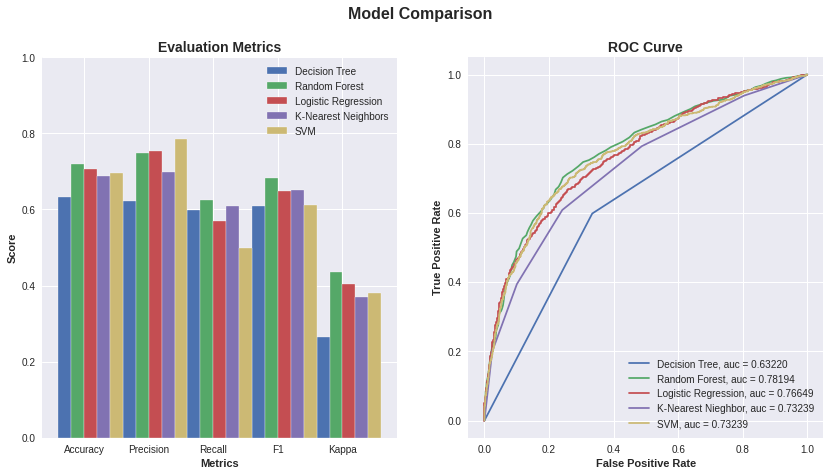

In [ ]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
dtc_score = [dtc_eval['acc'], dtc_eval['prec'], dtc_eval['rec'], dtc_eval['f1'], dtc_eval['kappa']]
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1'], rf_eval['kappa']]
nb_score = [nb_eval['acc'], nb_eval['prec'], nb_eval['rec'], nb_eval['f1'], nb_eval['kappa']]
knn_score = [knn_eval['acc'], knn_eval['prec'], knn_eval['rec'], knn_eval['f1'], knn_eval['kappa']]
svm_score=[SVM_eval['acc'],SVM_eval['prec'],SVM_eval['rec'],SVM_eval['f1'],SVM_eval['kappa']]
## Set position of bar on X axis
r1 = np.arange(len(dtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5=[x+ barWidth for x in r4]
## Make the plot
ax1.bar(r1, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r2, rf_score, width=barWidth, edgecolor='white', label='Random Forest')
ax1.bar(r3, nb_score, width=barWidth, edgecolor='white', label='Logistic Regression')
ax1.bar(r4, knn_score, width=barWidth, edgecolor='white', label='K-Nearest Neighbors')
ax1.bar(r5, svm_score, width=barWidth, edgecolor='white', label='SVM')

## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(dtc_eval['fpr'], dtc_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dtc_eval['auc']))
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(nb_eval['fpr'], nb_eval['tpr'], label='Logistic Regression, auc = {:0.5f}'.format(nb_eval['auc']))
ax2.plot(knn_eval['fpr'], knn_eval['tpr'], label='K-Nearest Nieghbor, auc = {:0.5f}'.format(knn_eval['auc']))
ax2.plot(SVM_eval['fpr'], SVM_eval['tpr'], label='SVM, auc = {:0.5f}'.format(knn_eval['auc']))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()